<a href="https://colab.research.google.com/github/dj311/uob-summer-project/blob/master/code/ML-adj-feature-matrix-conv-neural-network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(Uncompleted) Notebook for training and testing the baseline neural network model using adjacency matrices of the AST format of the buffer overflow datapoints. In order for the matrices to be fed into the neural network, they must all be of the same dimensions. We currently pick a subset of the data with small-ish AST matrices (614x614)

# Colab Setup

In [0]:
!mkdir -p /project/data && cd /project/data && wget -O adj.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
!mkdir -p /project/data && cd /project/data && wget -O adjacency-feature-matrix-random-padding-model-binary.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-feature-matrix-random-padding-model-binary.pickle
!mkdir -p /project/data && cd /project/data && wget -O adjacency-feature-matrix-model-binary.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-feature-matrix-model-binary.pickle
!mkdir -p /project/data && cd /project/data && wget -O buffer_overflow_data.csv.gz https://github.com/dj311/uob-summer-project/raw/master/data/buffer_overflow_data.csv.gz
!mkdir -p /project/data && cd /project/data && wget -O adjacency-matrix-model-binary.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-matrix-model-binary.pickle
!mkdir -p /project/data && cd /project/data && wget -O feature_matrix.pickle https://github.com/dj311/uob-summer-project/raw/master/data/feature_matrix.pickle
!mkdir -p /project/code
%cd /project/code

--2019-08-02 06:47:07--  https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle [following]
--2019-08-02 06:47:07--  https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1320521199 (1.2G) [application/octet-stream]
Saving to: ‘adj.pickle’

adj.pickle          100%[===================>]   1.23G   182MB/s    in 6.5s    

2019-08-02 06:47:29 (193 MB/s) - ‘adj.pickle’ saved [1320521199/13205

# Import & Preprocess Dataset

First we import the data from the [previous notebook](./adjacency_matrix.ipynb).


In [0]:
import tensorflow as tf
import keras
import sklearn
import numpy as np
import pickle
import random
import pandas as pd
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.model_selection import train_test_split


run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
np.random.seed(1248)

tf.logging.set_verbosity(tf.logging.INFO)

In [0]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [0]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [0]:
with open("../data/adj.pickle",'rb') as f:
    adj = pickle.load(f)

In [0]:
adj = adj.rename(columns={0: 'testcase_ID', 1: 'adjacency_matrix'})

In [0]:
orig_df = pd.merge(labels, adj, on='testcase_ID')

In [0]:
orig_df = orig_df[['testcase_ID', 'adjacency_matrix', 'bug']]

Next, find out the maximum size of an adjacency matrix, then convert all matrices to have the same dimension.

In [0]:
orig_df['matrix_size'] = orig_df.adjacency_matrix.apply(lambda x: x.shape[0])

In [0]:
orig_df['matrix_size'].describe()

count    21502.000000
mean      2186.138778
std       7239.752920
min          4.000000
25%        349.000000
50%        396.000000
75%        614.000000
max      44401.000000
Name: matrix_size, dtype: float64

So we know that 75% of the dataset has a matrix size <= 614, which is approximately 18000 datapoints. Picking the full dataset would require matrices of dimension 44401x44401 which require 15 gb of memory each. This is isn't feasible, however picking matrices of size 614x614 or less gives a per matrix size of 3.38mb - far more manageable!

In [0]:
matrix_size = 614
orig_df = orig_df[orig_df['matrix_size'] <= matrix_size]
len(orig_df)

16128

In [0]:
orig_df['random_pad_amount'] = orig_df['matrix_size'].apply(lambda m: random.randint(m,matrix_size))

In [0]:
adj_df = orig_df.copy()

In [0]:
def bottom_right_matrix_size_corrector(matrix, target_rows, target_columns):
    '''Pads matrix with zeros to the desired size'''
    
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    row_corrector = csr_matrix((target_rows-rows, columns))
    col_corrector = csr_matrix((target_rows, target_columns-columns))

    matrix = vstack([matrix, row_corrector])
    matrix = hstack([matrix, col_corrector])

    matrix = matrix.astype(np.int)
    
    return matrix 

In [0]:
adj_df['adjacency_matrix'] = adj_df['adjacency_matrix'].apply(lambda m: bottom_right_matrix_size_corrector(m, matrix_size, matrix_size))

Next we load in the feature matrices:

In [0]:
with open("../data/feature_matrix.pickle", "rb") as f:
    feature_matrix = pickle.load(f)

feature_matrix.columns = ['testcase_ID', 'feature_matrix']

In [0]:
num_features = 55

In [0]:
orig_df = pd.merge(feature_matrix, orig_df, on='testcase_ID')

In [0]:
feat_df = orig_df.copy()

In [0]:
feat_df['feature_matrix'] = feat_df['feature_matrix'].apply(lambda m: bottom_right_matrix_size_corrector(m, matrix_size, num_features))

In [0]:
testcase_ids = orig_df['testcase_ID'].values
adjacency_matrices = adj_df['adjacency_matrix'].values
feature_matrices = feat_df['feature_matrix'].values
labels = orig_df['bug'].values

Now we have a dataframe for each testcase with a sparse representation of its AST in the matrix column, each normalised to matrix_size x matrix_size in size.
  



Finally, we generate the train and test splits:

In [0]:
adj_train, adj_test, feat_train, feat_test, labels_train, labels_test = train_test_split(adjacency_matrices, feature_matrices, labels, test_size=0.2, random_state=0)

In [0]:
feat_train

array([<614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 341 stored elements in COOrdinate format>,
       <614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 271 stored elements in COOrdinate format>,
       <614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 57 stored elements in COOrdinate format>,
       ...,
       <614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 18 stored elements in COOrdinate format>,
       <614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 43 stored elements in COOrdinate format>,
       <614x55 sparse matrix of type '<class 'numpy.int64'>'
	with 266 stored elements in COOrdinate format>], dtype=object)

Storing all of these matrices in a dense representation at once might cause memory issues. To avoid this, we write a class which generates dense matrices for each of the training batches. 

We also perform the element wrapping as part of this process (since we can't perform it on the sparse arrays, I think).

In [0]:
class SparseToDenseGenerator(keras.utils.Sequence):

    def __init__(self, sparse_adjs, sparse_feats, labels, batch_size):
        self.sparse_adjs = sparse_adjs
        self.sparse_feats = sparse_feats
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.labels) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse_adjs = self.sparse_adjs[start_index:end_index]
        batch_sparse_feats = self.sparse_feats[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]
        
        batch_dense_adjs = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_adjs])
        batch_dense_feats = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_feats])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense_adjs = np.reshape(batch_dense_adjs, batch_dense_adjs.shape + (1, ))
        batch_dense_feats = np.reshape(batch_dense_feats, batch_dense_feats.shape + (1, ))

        return [batch_dense_adjs, batch_dense_feats], np.array(batch_labels)

# Model

In [0]:
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Convolution2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as K

In [0]:
batch_size = 96
epochs = 5
num_samples = len(labels)
num_features = feat_df.feature_matrix.iloc[0].shape[1]

datapoint_shape = (matrix_size, matrix_size, )
batch_shape = (batch_size, ) + datapoint_shape

steps_per_epoch = int(np.ceil(num_samples/batch_size))

kernel_size = (2, 2)
strides = max(kernel_size[0] // 3, 1)

batch_size, epochs, num_samples, datapoint_shape, batch_shape, steps_per_epoch, kernel_size, strides

(96, 5, 16128, (614, 614), (96, 614, 614), 168, (2, 2), 1)

In [0]:
# 1st: Convolutional Network on Adjacency Matrix
adjacency_input = keras.layers.Input(shape=(matrix_size, matrix_size, 1))

conv1 = Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
)(adjacency_input)
activation1 = Activation('relu')(conv1)
pool1 = MaxPooling2D(kernel_size, padding='same')(activation1)

conv2 = Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
)(pool1)
activation2 = Activation('relu')(conv2)
pool2 = MaxPooling2D(kernel_size, padding='same')(activation2)

conv3 = Conv2D(
    data_format='channels_last',
    input_shape=(matrix_size, matrix_size, 1),
    filters=32,
    kernel_size=kernel_size,
    strides=strides,
)(pool2)
activation3 = Activation('relu')(conv3)
pool3 = MaxPooling2D(kernel_size, padding='same')(activation3)

flatten = Flatten()(pool3)

dense1 = Dense(units=32, activation='relu')(flatten)
dense2 = Dense(units=32, activation='relu')(dense1)
dense3 = Dense(units=32, activation='relu')(dense2)

conv_model = keras.models.Model(inputs=adjacency_input, outputs=dense3)

# 2nd: Dense, Linear Network on Feature Matrix
features_input = keras.layers.Input(shape=(matrix_size, num_features, 1))

f_flatten = Flatten(data_format='channels_last')(features_input)

f_dense1 = Dense(units=614, activation='relu')(f_flatten)
f_dense2 = Dense(units=307, activation='relu')(f_dense1)
f_dense3 = Dense(units=150, activation='relu')(f_dense2)
f_dense4 = Dense(units=75, activation='relu')(f_dense3)
f_dense5 = Dense(units=32, activation='relu')(f_dense4)

dense_input = keras.models.Model(inputs = features_input, outputs= f_dense5)

# Combine outputs of both networks via a set of dense, linear layers
concat = keras.layers.concatenate(inputs=[conv_model.output ,dense_input.output])
c_dropout = Dropout(0.2)(concat)
c_dense1 =  Dense(units=64, activation='relu')(c_dropout)
c_dense2 =  Dense(units=64, activation='relu')(c_dense1)
c_dense3 =  Dense(units=64, activation='relu')(c_dense2)

# Dropout and final output layer
c_output = Dense(units=1, activation='sigmoid')(c_dense3)

model = keras.models.Model(inputs=[conv_model.input, dense_input.input], outputs=c_output)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

W0802 06:48:16.512894 140291274282880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0802 06:48:16.567075 140291274282880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0802 06:48:16.577412 140291274282880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0802 06:48:16.628159 140291274282880 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0802 06:48:16.801988 140291274282880 deprecation_wrapp

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 614, 614, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 613, 613, 32) 160         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 613, 613, 32) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 307, 307, 32) 0           activation_1[0][0]               
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
!pip install pydot

You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
  return model_to_dot(model).create(prog='dot', format='svg')

model_diagram = visualize_model(model)

with open('../images/adj-feat-architecture-cnn.svg', 'wb') as f:
    f.write(model_diagram)

SVG(model_diagram)

FileNotFoundError: ignored

In [0]:
training_batch_generator = SparseToDenseGenerator(adj_train, feat_train, labels_train, batch_size)

model.fit_generator(
    generator=training_batch_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/5
168/168 [==============================] - 2315s 14s/step - loss: 0.4749 - acc: 0.7472
Epoch 2/5
168/168 [==============================] - 2318s 14s/step - loss: 0.1735 - acc: 0.9285
Epoch 3/5
168/168 [==============================] - 2319s 14s/step - loss: 0.0922 - acc: 0.9644
Epoch 4/5
168/168 [==============================] - 2311s 14s/step - loss: 0.0592 - acc: 0.9783
Epoch 5/5
168/168 [==============================] - 2314s 14s/step - loss: 0.0542 - acc: 0.9779


In [0]:
with open('../data/adjacency-feature-matrix-model-binary.pickle', 'wb') as f:
    pickle.dump(model,f)

# Evaluation

In [0]:
model = None

with open('../data/adjacency-feature-matrix-model-binary.pickle', 'rb') as f:
    model = pickle.load(f)

In [0]:
test_batch_generator = SparseToDenseGenerator(adj_test, feat_test, labels_test, batch_size)

model.evaluate_generator(
    generator=test_batch_generator,
)

[0.06743317869967064, 0.9832609999793255]

In [0]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [0]:
class SparseToDensePredictGenerator(keras.utils.Sequence):

    def __init__(self, sparse_adjs, sparse_feats, batch_size):
        self.sparse_adjs = sparse_adjs
        self.sparse_feats = sparse_feats
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_feats) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse_adjs = self.sparse_adjs[start_index:end_index]
        batch_sparse_feats = self.sparse_feats[start_index:end_index]
        
        batch_dense_adjs = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_adjs])
        batch_dense_feats = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_feats])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense_adjs = np.reshape(batch_dense_adjs, batch_dense_adjs.shape + (1, ))
        batch_dense_feats = np.reshape(batch_dense_feats, batch_dense_feats.shape + (1, ))

        return [batch_dense_adjs, batch_dense_feats]

In [0]:
predict_batch_generator = SparseToDensePredictGenerator(adj_test, feat_test, batch_size)
y_predict = model.predict_generator(predict_batch_generator)

KeyboardInterrupt: ignored

E0801 20:29:29.769616 140340319106944 zmqstream.py:435] Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 421, in execute_request
    self._abort_queues()
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 637, in _abort_queues
    self._abort_queue(stream)
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py",

In [0]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(labels_test, np.rint(y_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(15, 12)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

NameError: ignored

In [0]:
np.argmax(labels_test.astype(int)), np.argmax(np.rint(y_predict)),

(4, 4)

In [0]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(
    labels_test.astype(int),
    np.rint(y_predict),
)

NameError: ignored

In [0]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
auc_keras = auc(fpr_keras, tpr_keras)

NameError: ignored

In [0]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

NameError: ignored

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    labels_test.astype(int), 
    np.rint(y_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

NameError: ignored

In [0]:
fpr_nn, fnr_nn

(0.0182370820668693, 0.015180265654648957)

## Random Padding (translational invariance)

In [0]:
import random

def random_padder(testcase, matrix_kind, target_rows, target_columns):
    '''
    Randomly pads matrix with zeros to the desired size
    '''
    
#     import pdb; pdb.set_trace()
    
    rand = testcase.random_pad_amount
    
    if matrix_kind == 'adj':
    
      matrix = testcase.adjacency_matrix
      
      rows, columns = matrix.shape[0], matrix.shape[1]
    
      tl_row_corrector = csr_matrix((rand-rows, rows))
      tl_col_corrector = csr_matrix((rand, rand-columns))
    
      tl_matrix = vstack([tl_row_corrector, matrix])
      tl_matrix = hstack([tl_col_corrector, tl_matrix])
    
      rows, columns = tl_matrix.shape[0], tl_matrix.shape[1]
    
      br_row_corrector = csr_matrix((target_rows-rows, rows))
      br_col_corrector = csr_matrix((target_columns, target_columns-columns))

      br_matrix = vstack([tl_matrix, br_row_corrector])
      br_matrix = hstack([br_matrix, br_col_corrector])   
    
    elif matrix_kind == 'feat':
      
      matrix = testcase.feature_matrix
      
      rows, columns = matrix.shape[0], matrix.shape[1]
    
      tl_row_corrector = csr_matrix((rand-rows, columns))
    
      tl_matrix = vstack([tl_row_corrector, matrix])
    
      rows, columns = tl_matrix.shape[0], tl_matrix.shape[1]
    
      br_row_corrector = csr_matrix((target_rows-rows, columns))

      br_matrix = vstack([tl_matrix, br_row_corrector])

    br_matrix = br_matrix.astype(np.int)
    
    return br_matrix

In [0]:
rand_adj_df = orig_df.copy()

In [0]:
rand_adj_df['padded_adj_matrix'] = rand_adj_df.apply(lambda m: random_padder(m, 'adj', matrix_size, matrix_size), axis = 1)

In [0]:
rand_feat_df = orig_df.copy()

In [0]:
rand_feat_df['padded_feat_matrix'] = rand_feat_df.apply(lambda m: random_padder(m, 'feat', matrix_size, num_features), axis = 1)

In [0]:
testcase_ids_rand = orig_df['testcase_ID'].values
adjacency_matrices_rand = rand_adj_df['padded_adj_matrix'].values
feature_matrices_rand = rand_feat_df['padded_feat_matrix'].values
labels_rand = orig_df['bug'].values

In [0]:
adj_train_rand, adj_test_rand, feat_train_rand, feat_test_rand, labels_train_rand, labels_test_rand = train_test_split(adjacency_matrices_rand, feature_matrices_rand, labels_rand, test_size=0.2, random_state=0)

In [0]:
test_batch_generator_rand = SparseToDenseGenerator(adj_test_rand, feat_test_rand, labels_test_rand, batch_size)

model.evaluate_generator(
    generator=test_batch_generator_rand,
)

[6.437767298119598, 0.5092994463938921]

51% accuracy when testing on the randomly padded when model was trained on normal padded

In [0]:
predict_batch_generator_rand = SparseToDensePredictGenerator(adj_test_rand, feat_test_rand, batch_size)
y_predict_rand = model.predict_generator(predict_batch_generator_rand)

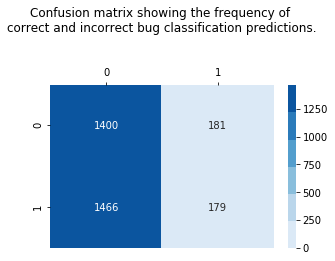

In [0]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(labels_test, np.rint(y_predict_rand)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [0]:
from sklearn.metrics import roc_curve
fpr_keras, tpr_keras, thresholds_keras = roc_curve(
    labels_test_rand.astype(int),
    np.rint(y_predict_rand),
)

In [0]:
from sklearn.metrics import auc
import matplotlib.pyplot as plt
auc_keras = auc(fpr_keras, tpr_keras)

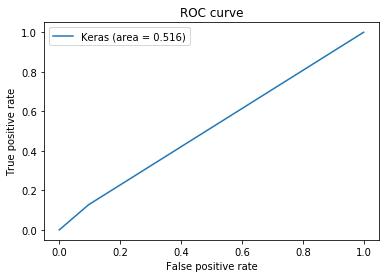

In [0]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Disgusting ROC curve

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    labels_test.astype(int), 
    np.rint(y_predict_rand)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

In [0]:
fpr_nn, fnr_nn

(0.5027777777777778, 0.5115143056524774)

Now we will use random padding for both training and testing the model

In [0]:
training_batch_generator = SparseToDenseGenerator(adj_train_rand, feat_train_rand, labels_train_rand, batch_size)

model.fit_generator(
    generator=training_batch_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/5
168/168 [==============================] - 2370s 14s/step - loss: 0.6393 - acc: 0.6051
Epoch 2/5
168/168 [==============================] - 2406s 14s/step - loss: 0.4986 - acc: 0.7237
Epoch 3/5
168/168 [==============================] - 2406s 14s/step - loss: 0.3004 - acc: 0.8537
Epoch 4/5
168/168 [==============================] - 2540s 15s/step - loss: 0.0799 - acc: 0.9722
Epoch 5/5
168/168 [==============================] - 2491s 15s/step - loss: 0.0467 - acc: 0.9825


In [0]:
with open('../data/adjacency-feature-matrix-random-padding-model-binary.pickle', 'wb') as f:
    pickle.dump(model,f)

In [0]:
model = None

with open('../data/adjacency-feature-matrix-random-padding-model-binary.pickle', 'rb') as f:
    model = pickle.load(f)

In [0]:
test_batch_generator_rand = SparseToDenseGenerator(adj_test_rand, feat_test_rand, labels_test_rand, batch_size)

model.evaluate_generator(
    generator=test_batch_generator_rand,
)

[0.5054043525135894, 0.8877867344589021]

In [0]:
predict_batch_generator_rand = SparseToDensePredictGenerator(adj_test_rand, feat_test_rand, batch_size)
y_predict_rand = model.predict_generator(predict_batch_generator_rand)

In [0]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(labels_test, np.rint(y_predict_rand)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(5, 3)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

NameError: ignored

In [0]:
fpr_keras, tpr_keras, thresholds_keras = roc_curve(
    labels_test_rand.astype(int),
    np.rint(y_predict_rand),
)

In [0]:
auc_keras = auc(fpr_keras, tpr_keras)
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    labels_test.astype(int), 
    np.rint(y_predict_rand)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

fpr_nn, fnr_nn

Now testing the model trained on random padding on the 'originally padded' matrices

In [0]:
test_batch_generator = SparseToDenseGenerator(adj_test, feat_test, labels_test, batch_size)

model.evaluate_generator(
    generator=test_batch_generator,
)

[5.511991235090942, 0.5365778041861475]

53.65% accuracy, poo :(